In [440]:
import numpy as np

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import pandas as pd
import graphviz
import matplotlib.pyplot as plt

In [441]:
# Parameters
random_state = 7
min_samples_leaf = 5

## 1) Get an artificial inflation of some class in the training set by a given factor: 10 (weigh more the classes virginica e versicolor which are more difficult to discriminate). Learn the tree in these conditions.

In [442]:
# data, target = load_iris(return_X_y=True)
iris = load_iris()
inflation_factor = 10

# Compute the repetitions of each elem of the dataset
repetitions = np.clip(iris.target * inflation_factor, a_min=1, a_max=inflation_factor)

# Apply inflation to dataset
inflated_data = np.repeat(iris.data, repetitions, axis=0)
inflated_target = np.repeat(iris.target, repetitions, axis=0)

# Get train & test datasets
X_train, X_test, y_train, y_test_inf = train_test_split(inflated_data, inflated_target, test_size=0.2, random_state=random_state+1)

# Learning of the tree
clf_inflated = tree.DecisionTreeClassifier(criterion="entropy", random_state=random_state, min_samples_leaf=5)
clf_inflated = clf_inflated.fit(X_train, y_train)

# Get predictions
y_pred_inf = clf_inflated.predict(X_test)

# Show pairs
pd.DataFrame(np.column_stack((y_pred_inf, y_test_inf)).T, index=['prediction', 'reference'])

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
prediction,1,1,1,1,1,1,2,2,1,2,...,1,2,1,2,1,2,1,1,2,2
reference,1,1,1,1,1,1,2,2,1,2,...,1,2,1,2,1,2,1,1,2,2


### Evaluation

In [443]:
accuracy = accuracy_score(y_test_inf, y_pred_inf)
report = classification_report(y_test_inf, y_pred_inf, labels=[0, 1, 2])

print(f'Accuracy: {accuracy * 100}%')
print(report)

Accuracy: 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       106
           2       1.00      1.00      1.00        94

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



### Graph

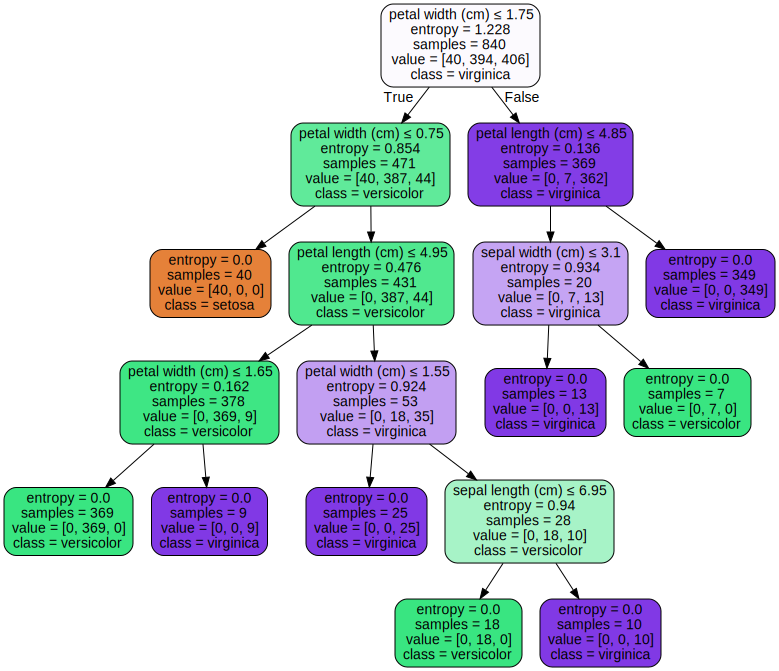

In [444]:
dot_data = tree.export_graphviz(clf_inflated, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## 2) Modify the weight of some classes (set to 10 the weights for misclassification between virginica into versicolor and vice versa) and learn the tree in these conditions. You should obtain similar results as for step 1.

In [445]:
misc_weight = 10

X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test_w = train_test_split(X, y, test_size=0.2, random_state=random_state+1)
clf_weighted = tree.DecisionTreeClassifier(criterion="entropy", random_state=random_state, min_samples_leaf=min_samples_leaf, class_weight={0:1, 1:misc_weight, 2:misc_weight})

# Learning of the tree applying weights
clf_weighted.fit(X_train, y_train)

# Get predictions
y_pred_w = clf_weighted.predict(X_test)

# Show pairs
pd.DataFrame(np.column_stack((y_pred_w, y_test)).T, index=['prediction', 'reference'])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
prediction,0,0,0,2,1,0,0,2,2,1,...,1,0,1,1,1,0,2,0,0,2
reference,0,0,0,2,1,0,0,2,2,1,...,1,0,1,1,1,0,2,0,0,2


### Evaluation

In [446]:
accuracy = accuracy_score(y_test_w, y_pred_w)
report = classification_report(y_test_w, y_pred_w, labels=[0, 1, 2])

print(f'Accuracy: {accuracy * 100}%')
print(report)

Accuracy: 86.66666666666667%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



### Graph

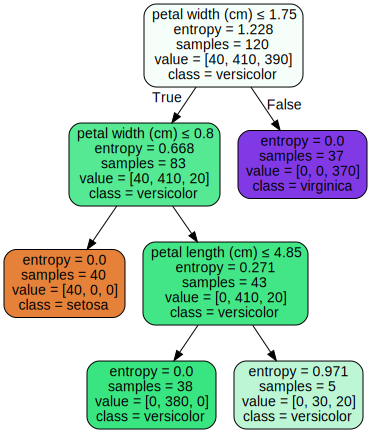

In [447]:
dot_data = tree.export_graphviz(clf_weighted, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## 3) Learn trees but avoid overfitting (by improving the error on the test set) tuning the parameters on: the minimum number of samples per leaf, max depth of the tree, min_impurity_decrease parameters, max leaf nodes, etc.

In [448]:
X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state+1)

best_score = 0
hyperparameters = list()

# Tuning hyperparameters
for min_samples_l in range(2, 15):
    for max_leaf_n in range(2, 15):
        for min_samples_s in range(2, 30):
            for impurity in np.linspace(0, 1, 21):
                clf_improved = tree.DecisionTreeClassifier(criterion="entropy", 
                                                            random_state=random_state, 
                                                            min_samples_leaf=min_samples_l, 
                                                            max_leaf_nodes=max_leaf_n, 
                                                            min_samples_split=min_samples_s, 
                                                            min_impurity_decrease=impurity)
                clf_improved = clf_improved.fit(X_train, y_train)
                y_pred_imp = clf_improved.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred_imp)
                f1 = f1_score(y_test, y_pred_imp, average='macro')
                if accuracy + f1 > best_score:
                    best_score = accuracy + f1
                    hyperparameters.clear()
                elif accuracy + f1 == best_score:
                    hyperparameters.append([min_samples_l, max_leaf_n, min_samples_s, impurity])

In [449]:
clf_improved = tree.DecisionTreeClassifier(criterion="entropy", random_state=random_state, min_samples_leaf=hyperparameters[0][0], max_leaf_nodes=hyperparameters[0][1], min_samples_split=hyperparameters[0][2], min_impurity_decrease=hyperparameters[0][3])
clf_improved = clf_improved.fit(X_train, y_train)
y_pred_imp = clf_improved.predict(X_test)

# Show pairs
pd.DataFrame(np.column_stack((y_pred_imp, y_test)).T, index=['prediction', 'reference'])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
prediction,0,0,0,2,1,0,0,2,2,1,...,1,0,1,1,1,0,2,0,0,2
reference,0,0,0,2,1,0,0,2,2,1,...,1,0,1,1,1,0,2,0,0,2


In [450]:
mat = np.array(hyperparameters)
df = pd.DataFrame(mat, columns=["min_samples_leaf", "max_leaf_nodes", "min_samples_split", "min_impurity_decrease"])
df.sort_values(["min_samples_leaf", "max_leaf_nodes", "min_samples_split", "min_impurity_decrease"], inplace=True)
df.to_html("optimized_hyperparameters.html")

Reading the table created with the optimized hyperparameters we see that:
* <b>min_samples_leaf</b>: from 2 to 3
* <b>max_leaf_nodes</b>: from 4 to 14
* <b>min_samples_split</b>: from 2 to 29
* <b>min_impurity_decrease</b>: 0 to 0.05

## 4) Build the confusion matrix of the created tree models on the test set and show them. 

In [451]:
inflated_confusion_matrix = confusion_matrix(y_true=y_test_inf, y_pred=y_pred_inf)
weighted_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_w)
improved_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_imp)

print("Inflated Confusion Matrix")
print(pd.DataFrame(inflated_confusion_matrix, index=iris.target_names, columns=iris.target_names))
print("\nWeighted Confusion Matrix")
print(pd.DataFrame(weighted_confusion_matrix, index=iris.target_names, columns=iris.target_names))
print("\nImproved Confusion Matrix")
print(pd.DataFrame(improved_confusion_matrix, index=iris.target_names, columns=iris.target_names))

Inflated Confusion Matrix
            setosa  versicolor  virginica
setosa          10           0          0
versicolor       0         106          0
virginica        0           0         94

Weighted Confusion Matrix
            setosa  versicolor  virginica
setosa          10           0          0
versicolor       0           8          1
virginica        0           3          8

Improved Confusion Matrix
            setosa  versicolor  virginica
setosa          10           0          0
versicolor       0           8          1
virginica        0           2          9


## 5) Build the ROC curves (or coverage curves in coverage space) and plot them for each tree model you have created: for each model you have to build three curves, one for each class, considered in turn as the positive class.

In [452]:
X_roc = iris.data
y_roc = label_binarize(iris.target, classes=[0, 1, 2]) # from multiclass to binary

n_classes = len(iris.target_names)
n_samples = y_test.shape[0]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_roc, y_roc, test_size=0.2, random_state=random_state+1)

subplot_kw = dict(
        xlabel=('False Positive Rate'), 
        xlim=([0.0, 1.0]), 
        ylabel=('True Positive Rate'), 
        ylim=([0.0, 1.01]))
        

def compute_roc(classifier, weighted: bool):
    if weighted:
        y_score_bin = classifier.predict_proba(X_test)
    else:
        classifier = OneVsRestClassifier(classifier)
        y_score_bin = classifier.fit(X_train_bin, y_train_bin).predict_proba(X_test_bin)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return (fpr, tpr, roc_auc)


def plot_rocs(title: str, fpr, tpr, roc_auc):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(25, 7), sharex=True, subplot_kw=subplot_kw)

    i = 0
    ax0.set_title(iris.target_names[i])
    ax0.plot(fpr[i], tpr[i], color='blue', lw=2, label=f'AUC = {roc_auc[i]})')
    ax0.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax0.legend(loc="lower right")

    i = 1
    ax1.set_title(iris.target_names[i])
    ax1.plot(fpr[i], tpr[i], color='red', lw=2, label=f'AUC = {roc_auc[i]})')
    ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax1.legend(loc="lower right")

    i = 2
    ax2.set_title(iris.target_names[i])
    ax2.plot(fpr[i], tpr[i], color='green', lw=2, label=f'AUC = {roc_auc[i]})')
    ax2.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax2.legend(loc="lower right")

    fig.suptitle(f'ROCs of {title}')
    return fig

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_16796\2721521542.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_rocs("Inflated Tree", *compute_roc(clf_inflated, False)).show()


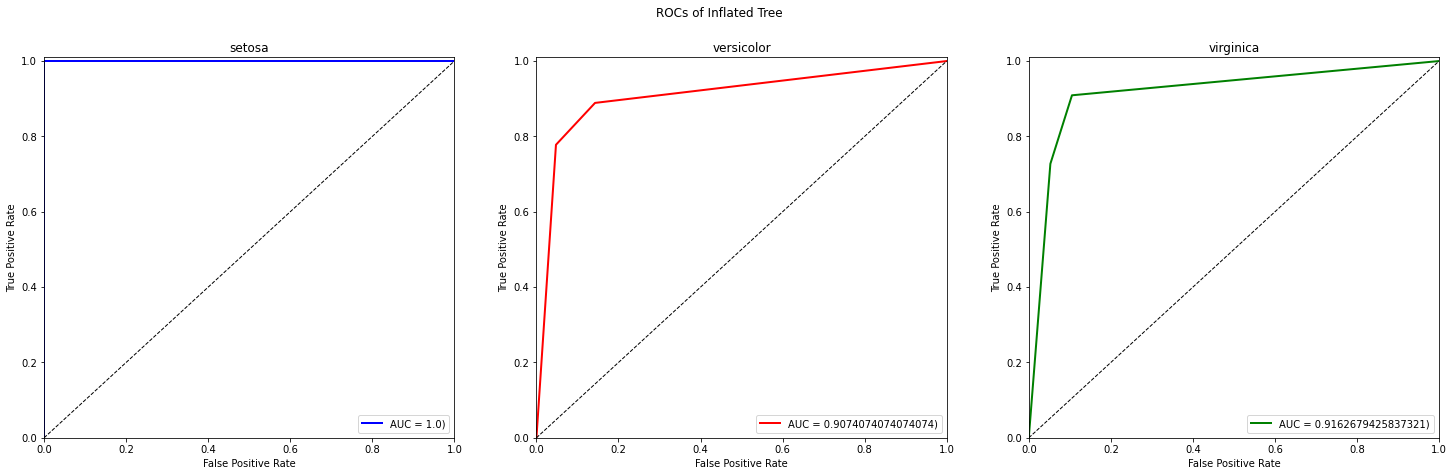

In [453]:
# Inflated Tree
plot_rocs("Inflated Tree", *compute_roc(clf_inflated, False)).show()

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_16796\1187100031.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_rocs("Weighted Tree", *compute_roc(clf_weighted, True)).show()


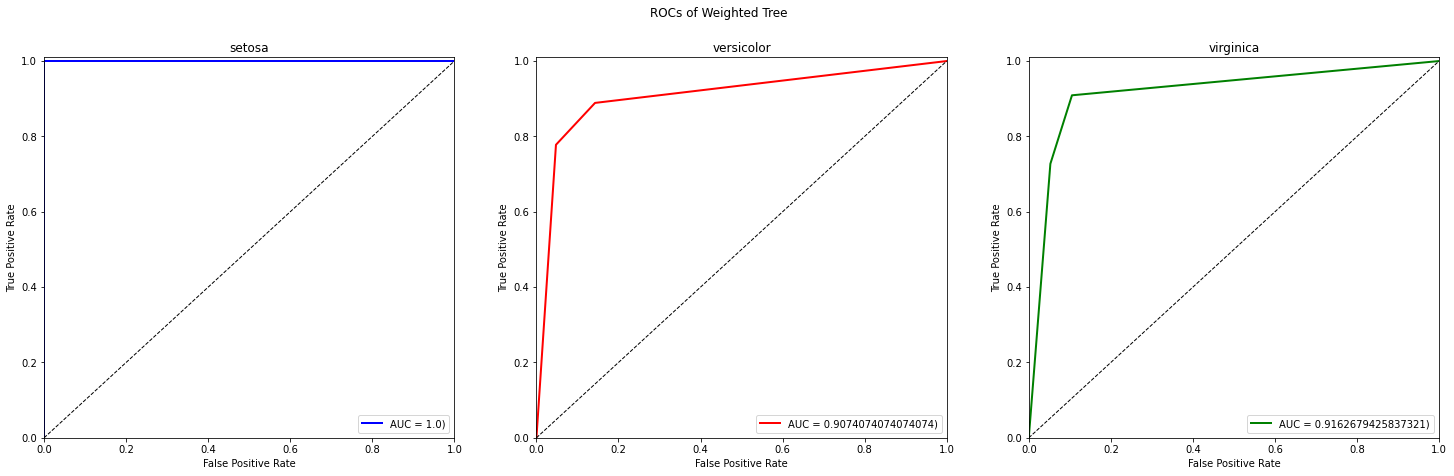

In [454]:
# Weighted case
plot_rocs("Weighted Tree", *compute_roc(clf_weighted, True)).show()

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_16796\2914534311.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_rocs("Improved Tree", *compute_roc(clf_improved, False)).show()


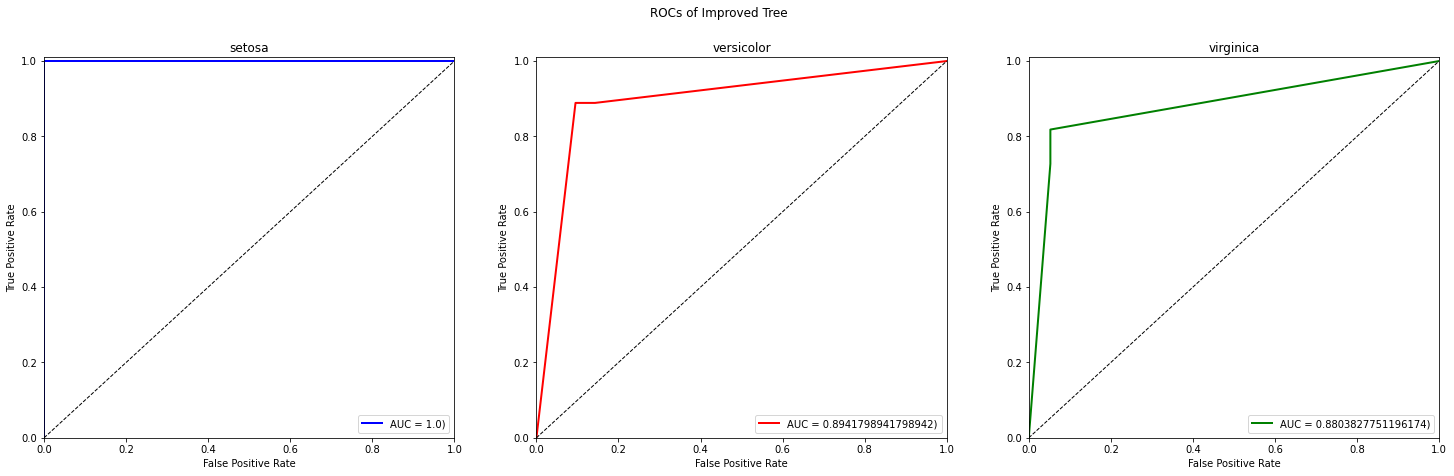

In [455]:
# Improved (or optimized) case
plot_rocs("Improved Tree", *compute_roc(clf_improved, False)).show()